# 1. Validation

The following code serves for determining the right exponent of the convective velocity $\alpha$

$u_{dis} = u_0 * (1-x^{\alpha})$

Inputs are:
- alpha = List with exponent's values. should be as few as possible. Computationally very expensive
- experiment = The type of substance being analysed ("2mmol_21C", "2mmol_30C", "5mmol_30C", "10mmol_21C", "10mmol_30C", "15mmol_20C", "15mmol_30C")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import helper_functions as hf
from sim_run import run_sim
import csv
from sim_run_parallel_validation import parallel_simulation

alpha = [1, 1.5, 2.0, 2.5]
experiment = "2mmol_21C"

total_guess = np.zeros(len(alpha))

for k in range(len(alpha)):
    N_CPU = 8    
    if (experiment =="2mmol_21C"):
        tests = [1, 9, 19]
        dpz_e = [0, 0, 1]
    elif(experiment=="2mmol_30C"):
        tests = [32, 42]
        dpz_e = [1, 1]
    elif(experiment=="5mmol_30C"):
        tests = [78, 104]
        dpz_e = [1, 1]
    elif(experiment=="10mmol_21C"):
        tests = [146, 111, 116, 149, 120, 152, 155, 122, 158, 157, 132, 160, 137, 143]
        dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
    elif(experiment=="10mmol_30C"):
        tests = [176, 174, 182, 181, 189, 188, 196, 194, 203, 201, 220, 229]
        dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
    elif(experiment=="15mmol_20C"):
        tests = [237, 236, 245, 243, 252, 250, 258, 255, 265, 262, 273, 269, 282, 292]
        dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
    elif(experiment=="15mmol_30C"):
        tests = [300, 299, 307, 306, 314, 312, 321, 318, 328, 325, 338, 332, 347, 357]
        dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
    else:
        raise('Unrecognized experiment name')
    
    df = pd.read_excel("Input/data_main.xlsx", sheet_name="sozh")
    df = df.iloc[tests]
    exp = df['exp'].tolist()
    phi_0 = df['phi_0'].tolist()
    dV_ges = df['dV_ges'].tolist()
    eps_0 = df['eps_0'].tolist()
    h_c_0 = df['h_c_0'].tolist()
    h_dis_0 = df['h_dis_0'].tolist()
    dpz_m = np.zeros(len(dpz_e))
    guess = 0

    exponent = alpha[k]

    parameters = [(exp[i], phi_0[i], dV_ges[i], eps_0[i], h_c_0[i], h_dis_0[i]) for i in range(len(exp))]
    results = joblib.Parallel(n_jobs=N_CPU, backend='multiprocessing')(joblib.delayed(parallel_simulation)(param) for param in parameters)

    for j in range(len(results)):
        dpz_m[j] = 1 if (results[j]['dpz_flooded']) else 0
        if (dpz_m[j]==dpz_e[j]):
            guess =+1
        else:
            continue
    total_guess[k] = guess

plt.bar(alpha, total_guess, width=0.2)
plt.xlabel('alpha')
plt.ylabel('Correct guess')
plt.grid()
plt.show()

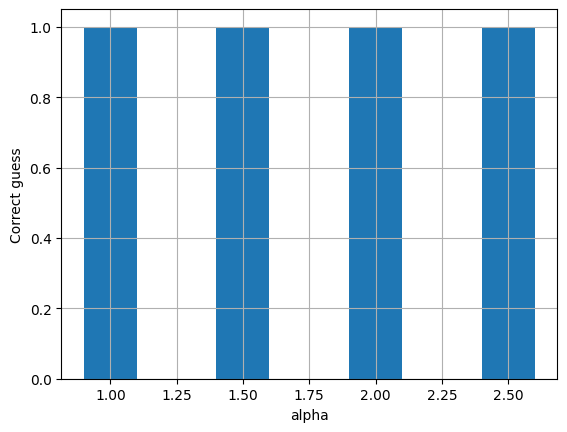

In [51]:
plt.bar(alpha, total_guess, width=0.2)
plt.xlabel('alpha')
plt.ylabel('Correct guess')
plt.grid()
plt.show()

## Information about tests

All the tests are contained in data_main.xlsx. For filtering per experiment, the following information is needed:

In [ ]:
if (experiment =="2mmol_21C"):
    tests = [1, 9, 19]
    dpz_e = [0, 0, 1]
elif(experiment=="2mmol_30C"):
    tests = [32, 42]
    dpz_e = [1, 1]
elif(experiment=="5mmol_30C"):
    tests = [78, 104]
    dpz_e = [1, 1]
elif(experiment=="10mmol_21C"):
    tests = [146, 111, 116, 149, 120, 152, 155, 122, 158, 157, 132, 160, 137, 143]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="10mmol_30C"):
    tests = [176, 174, 182, 181, 189, 188, 196, 194, 203, 201, 220, 229]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="15mmol_20C"):
    tests = [237, 236, 245, 243, 252, 250, 258, 255, 265, 262, 273, 269, 282, 292]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
elif(experiment=="15mmol_30C"):
    tests = [300, 299, 307, 306, 314, 312, 321, 318, 328, 325, 338, 332, 347, 357]
    dpz_e = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
else:
    raise('Unrecognized experiment name')

TypeError: exceptions must derive from BaseException

<BarContainer object of 2 artists>

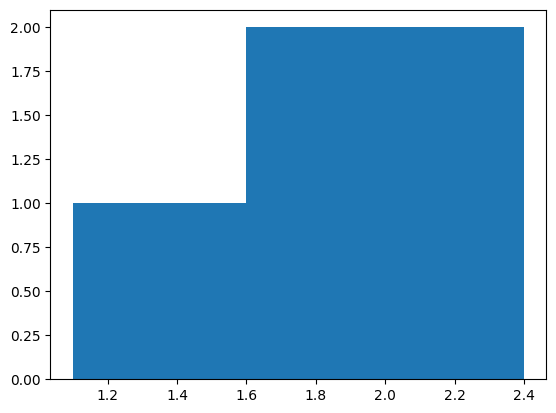

In [39]:
alpha = [1.5, 2]
total_guess = np.zeros(len(alpha))
dpz_e = [0, 0, 1]
dpz_m = np.zeros(len(dpz_e))
guess = 0

for j in range(len(results)):
    dpz_m[j] = 1 if (results[j]['dpz_flooded']) else 0
    if (dpz_m[j]==dpz_e[j]):
        guess =+1
    else:
        continue

total_guess[0] = guess
total_guess[1] = 2*guess


plt.bar(alpha, total_guess)